# Simulate neural time series using neuroDSP

In [1]:
# Import sim functions
import numpy as np
import pandas as pd

from scipy.linalg import norm
from itertools import repeat

from neurodsp.sim import sim_powerlaw
from neurodsp.utils import set_random_seed

# Import function to compute power spectra
from neurodsp.spectral import compute_spectrum

# Import utilities for plotting data
from neurodsp.utils import create_times
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series

In [2]:
# useful functions
def sim_peak_oscillation(sig_ap, fs, freq, bw, height):
    """Simulate a signal with an aperiodic component and a specific oscillation peak.
    Parameters
    ----------
    sig_ap : 1d array
        The timeseries of the aperiodic component.
    fs : float
        Sampling rate of ``sig_ap``.
    freq : float
        Central frequency for the gaussian peak in Hz.
    bw : float
        Bandwidth, or standard deviation, of gaussian peak in Hz.
    height : float
        Relative height of the gaussian peak at the central frequency ``freq``.
        Units of log10(power), over the aperiodic component.
    Returns
    -------
    sig : 1d array
        Time series with desired power spectrum.
    Notes
    -----
    - This function creates a time series whose power spectrum consists of an aperiodic component
    and a gaussian peak at ``freq`` with standard deviation ``bw`` and relative ``height``.
    - The periodic component of the signal will be sinusoidal.
    Examples
    --------
    Simulate a signal with aperiodic exponent of -2 & oscillation central frequency of 20 Hz:
    >>> from neurodsp.sim import sim_powerlaw
    >>> fs = 500
    >>> sig_ap = sim_powerlaw(n_seconds=10, fs=fs)
    >>> sig = sim_peak_oscillation(sig_ap, fs=fs, freq=20, bw=5, height=7)
    """

    sig_len = len(sig_ap)
    times = create_times(sig_len / fs, fs)
    
    freq1=freq[0]
    freq2=freq[1]
    bw1=bw[0]
    bw2=bw[1]
    height1=height[0]
    height2=height[1]

    # Construct the aperiodic component and compute its Fourier transform
    # Only use the first half of the frequencies from the FFT since the signal is real
    sig_ap_hat = np.fft.fft(sig_ap)[0:(sig_len // 2 + 1)]

    # Create the range of frequencies that appear in the power spectrum since these
    # will be the frequencies in the cosines we sum below
    freqs = np.linspace(0, fs / 2, num=sig_len // 2 + 1, endpoint=True)

    # Construct the array of relative heights above the aperiodic power spectrum
    rel_heights1 = np.array([height1 * np.exp(-(lin_freq - freq1) ** 2 / (2 * bw1 ** 2)) \
        for lin_freq in freqs])
        
    # Construct the array of relative heights above the aperiodic power spectrum
    rel_heights2 = np.array([height2 * np.exp(-(lin_freq - freq2) ** 2 / (2 * bw2 ** 2)) \
            for lin_freq in freqs])
        
    rel_heights= rel_heights1+rel_heights2

    # Build an array of the sum of squares of the cosines to use in the amplitude calculation
    cosine_norms = np.array([norm(np.cos(2 * np.pi * lin_freq * times), 2) ** 2 \
        for lin_freq in freqs])

    # Build an array of the amplitude coefficients
    cosine_coeffs = np.array([\
        (-np.real(sig_ap_hat[ell]) + np.sqrt(np.real(sig_ap_hat[ell]) ** 2 + \
        (10 ** rel_heights[ell] - 1) * np.abs(sig_ap_hat[ell]) ** 2)) / cosine_norms[ell] \
        for ell in range(cosine_norms.shape[0])])

    # Add cosines with the respective coefficients and with a random phase shift for each one
    sig_periodic = np.sum(np.array([cosine_coeffs[ell] * \
                                   np.cos(2 * np.pi * freqs[ell] * times + \
                                          2 * np.pi * np.random.rand()) \
                          for ell in range(cosine_norms.shape[0])]), axis=0)

    sig = sig_ap + sig_periodic

    return sig

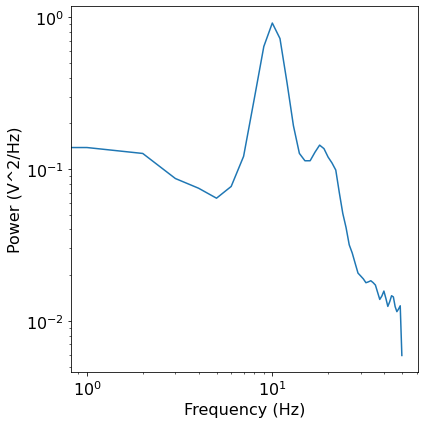

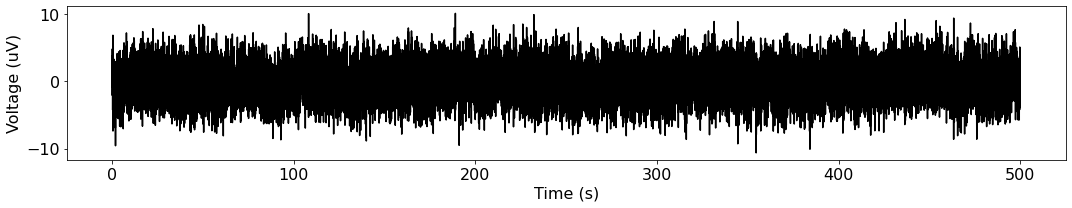

In [7]:
# Run example simulated Spectra using NeuroDSP
# Set some general settings, to be used across all simulations
fs = 100 # sampling rate
n_seconds = 500 # length of recording 
times = create_times(n_seconds, fs)

alpha_freq=10
alpha_bw=2
alpha_height=1.5

beta_freq=19
beta_bw=5
beta_height=1

expon= -0.7
# Simulate aperiodic element
signal = sim_powerlaw(n_seconds, fs, expon)
# Simulate periodic element
signal = sim_peak_oscillation(signal, fs, [alpha_freq, beta_freq], [alpha_bw, beta_bw], [alpha_height, beta_height])
freqs, psd = compute_spectrum(signal, fs)
plot_power_spectra(freqs, psd)

plot_time_series(times, signal)

In [6]:
# simulate exponent and keep alpha and beta params constant
parameters_used=pd.DataFrame({'SubID' : [], 'peak_freq' : [], 'peak_band' : [], 'peak_height' : [], 'aper_expon' : [], 'group': []})

# range of exponential values to simulate 
expons= [-0.6, -0.7, -0.8, -0.9, -1.0, -1.1, -1.2, -1.3, -1.4, -1.5]


for j in expons:
    for i in range(500):
        # Set some general settings, to be used across all simulations
        fs = 500 # sampling rate
        n_seconds = 30 # length of recording 

        alpha_freq=10
        alpha_bw=2
        alpha_height=0.7

        beta_freq=19
        beta_bw=5
        beta_height=0.4

        expon= j
        # Simulate aperiodic element
        signal = sim_powerlaw(n_seconds, fs, expon)
        # Simulate periodic element
        signal = sim_peak_oscillation(signal, fs, [alpha_freq, beta_freq], [alpha_bw, beta_bw], [alpha_height, beta_height])
        np.savetxt('./data/exponEPHYS/sim' + '_expon_' + str(-1*expon) + '_simulation_ No_' + str(i) + '.csv', signal, delimiter=",")




In [8]:
# simulate short segments of neurophysiological with constnat arrhythmic
# systematically vary the alpha amplitude parameter
parameters_used=pd.DataFrame({'SubID' : [], 'peak_freq' : [], 'peak_band' : [], 'peak_height' : [], 'aper_expon' : [], 'group': []})

expons= [0.3, 0.5, 0.7, 0.9, 1, 1.2, 1.4, 1.6, 1.8, 2]


for j in expons:
    for i in range(500):
        # Set some general settings, to be used across all simulations
        fs = 500 # sampling rate
        n_seconds = 30 # length of recording 

        alpha_freq=10
        alpha_bw=2
        alpha_height=j

        beta_freq=19
        beta_bw=5
        beta_height=0.4

        expon= -1
        # Simulate aperiodic element
        signal = sim_powerlaw(n_seconds, fs, expon)
        # Simulate periodic element
        signal = sim_peak_oscillation(signal, fs, [alpha_freq, beta_freq], [alpha_bw, beta_bw], [alpha_height, beta_height])
        np.savetxt('./data/ampEPHYS/sim' + '_amp_' + str(alpha_height) + '_simulation_ No_' + str(i) + '.csv', signal, delimiter=",")




In [9]:
# systematically vary the alpha centre frequency parameter
parameters_used=pd.DataFrame({'SubID' : [], 'peak_freq' : [], 'peak_band' : [], 'peak_height' : [], 'aper_expon' : [], 'group': []})

expons= [4,5,6,7,8,9,10,11,12,13,14]


for j in expons:
    for i in range(500):
        # Set some general settings, to be used across all simulations
        fs = 500 # sampling rate
        n_seconds = 30 # length of recording 

        alpha_freq=j
        alpha_bw=2
        alpha_height=0.7

        beta_freq=19
        beta_bw=5
        beta_height=0.4

        expon= -1
        # Simulate aperiodic element
        signal = sim_powerlaw(n_seconds, fs, expon)
        # Simulate periodic element
        signal = sim_peak_oscillation(signal, fs, [alpha_freq, beta_freq], [alpha_bw, beta_bw], [alpha_height, beta_height])
        np.savetxt('./data/FreqEPHYS/sim' + '_freq_' + str(alpha_freq) + '_simulation_ No_' + str(i) + '.csv', signal, delimiter=",")


# Simulate ccorrelations between alpha power and expon

In [78]:
# create a matrix of parameters (alpha power and age) with prespecific correlation structure
# then simulate 100 time series with these properties

import numpy as np
import pandas as pd
import scipy.stats
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
MASS = importr('MASS')                       # Must use R: install.packages('MASS')
r = robjects.r

num_samples = 100
effectsizes= [-0.0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9]


for j in effectsizes:

    data=np.matrix(MASS.mvrnorm(n = num_samples, mu = r.c(1,40), Sigma = r.matrix(r.c(1,j,j,1), nrow=2), empirical = True))
    Y= np.array(data[:,1].flatten())[0]
    X= np.array(data[:,0].flatten())[0]
    X=((X-min(X))/(max(X)-min(X)))+0.1
    
    datafranme = {
      "expon": X,
      "age": Y
    }
    df = pd.DataFrame(datafranme)

    df.to_csv('./data/correlatedAlphaLowAmp2/simulated_correlations_' + str(-1*j) +  '_sample.csv')


    for i in range(num_samples):
        # Set some general settings, to be used across all simulations
        fs = 500 # sampling rate
        n_seconds = 30 # length of recording 

        alpha_freq=10
        alpha_bw=2
        alpha_height=X[i]

        beta_freq=19
        beta_bw=5
        beta_height=0.4

        expon= -1
        print(alpha_height)
        # Simulate aperiodic element
        signal = sim_powerlaw(n_seconds, fs, expon)
        # Simulate periodic element
        signal = sim_peak_oscillation(signal, fs, [alpha_freq, beta_freq], [alpha_bw, beta_bw], [alpha_height, beta_height])
        np.savetxt('./data/correlatedAlphaLowAmp2/sim_' + str(-1*j) + '/sim' + '_amp_' + str(-1*j) + '_simulation_ No_' + str(i) + '.csv', signal, delimiter=",")


0.6579779150310635
0.6295801618603449
0.7943215361883411
0.5353533702837023
0.7474533671698648
0.5807133184130084
0.820122186587082
0.9992245022148896
0.44046988484748606
0.5424997582961253
0.9133127317062703
0.8930302347218033
0.7239873979691
1.0574263408433768
0.7305743850491209
0.7511245658725396
0.28994015212589064
0.6675259608929588
0.5656525913779833
0.9507186004558431
0.6117915721472679
0.5938173015852349
0.7416900412672269
0.49952238974308505
0.7668686522504409
0.9677830274596034
0.3994085108670542
0.5907183716087653
0.691459757843922
0.5180044772784601
0.5939364219390467
0.7923766058671184
0.5117464439961961
0.5913802186168596
0.2961948847800965
0.551360012625886
0.7181026535808499
0.5932650575563339
0.6942982449233326
0.7295856879791405
0.42853385737617167
0.5646061652765451
0.5963332949233681
0.7550563990806943
0.1
0.6878285327633433
0.6242611644458571
1.0441728090821831
0.5916871615853929
0.6445026219180077
0.8501335126029306
0.5441353103450535
0.6812874797195345
0.74301279

0.38575064895774713
0.46998479436457863
0.6419302216617169
0.8511626005927988
0.7802342541700464
0.8158388576962587
0.5107424314184569
0.17984637094081427
0.5689681758026237
0.7835229875277608
0.5792724474627894
0.42288727835325446
0.46700827813094015
0.7308032100641961
1.1
0.4847479828249899
0.3562250611562896
0.43265767691088786
0.6775545970268003
0.6429300628087207
0.5397789599689083
0.6922558807907213
1.0216034853972291
0.1
0.5530548120923674
0.7742715561796177
0.654866290690452
0.42017046194751173
0.440672421218843
0.5708605601596269
0.9089005884480709
0.8141695717357696
0.3579038274916557
0.6154703480893364
0.466915988841634
0.6798212179096612
0.8359738640488188
0.5006918235597132
0.6321327889179017
0.7550770883747102
0.7833151877169123
0.49197493439368156
0.48984137853015175
0.7239595431853953
0.31352470001826194
0.6463377323462257
0.41456315799268184
0.7168438656688635
0.6124662751981189
0.5566642025710069
0.5263253496570545
0.518930652081829
0.8517294100330941
0.67377801530135

0.6634245010072618
0.7281711064627762
1.083710337897217
0.3683670492503961
0.9234443193567191
0.441066358093839
0.9849735224121412
0.8617999171415319
0.5822464010922134
0.7422834154061628
0.2635733306181318
0.6223604168315932
1.0742299112759968
0.42216378280175404
0.1
0.7428653364932438
0.5211794733641033
0.6900200125196929
0.7507685091179253
0.4511796431408296
0.4588328980165438
0.6344154879585696
0.8022922725434926
0.6524501576918247
0.5826767156824344
0.9462342343446561
0.8683914620711293
0.7246022397742048
1.038920086895206
0.6461387546674169
0.734417322813037
0.5160865815843836
0.7130463304561055
0.336608385022788
0.7577282687207119
0.47771168481409365
0.5819684630727026
0.28669051782236815
0.5421371459307377
0.4760504417002629
0.5840776282302926
0.8722437581821821
0.49623593797949994
0.6176960153368953
0.6297833343760815
0.5095971089153665
0.6588438273547397
0.40691838677683057
0.5892822995965501
0.45338261544707426
0.43922491919321516
0.7905211634202748
0.39411434427184067
0.697

In [3]:
# create a matrix of parameters (alpha power and expon) with prespecific correlation structure
# then simulate 100 time series with these properties

import numpy as np
import pandas as pd
import scipy.stats
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
MASS = importr('MASS')                       # Must use R: install.packages('MASS')
r = robjects.r

num_samples = 100
effectsizes= [-0.0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9]


for j in effectsizes:

    data=np.matrix(MASS.mvrnorm(n = num_samples, mu = r.c(1,40), Sigma = r.matrix(r.c(1,j,j,1), nrow=2), empirical = True))
    Y= np.array(data[:,1].flatten())[0]
    X= np.array(data[:,0].flatten())[0]
    X=((X-min(X))/(max(X)-min(X)))+0.1
    Y=((Y-min(Y))/(max(Y)-min(Y)))+0.5
    
    datafranme = {
      "expon": X,
      "age": Y
    }
    df = pd.DataFrame(datafranme)

    df.to_csv('./data/exponalphacorr/simulated_correlations_' + str(-1*j) +  '_sample.csv')


    for i in range(num_samples):
        # Set some general settings, to be used across all simulations
        fs = 500 # sampling rate
        n_seconds = 30 # length of recording 

        alpha_freq=10
        alpha_bw=2
        alpha_height=X[i]

        beta_freq=19
        beta_bw=5
        beta_height=0.4

        expon= Y[i]
        print(expon)
        # Simulate aperiodic element
        signal = sim_powerlaw(n_seconds, fs, -1*expon)
        # Simulate periodic element
        signal = sim_peak_oscillation(signal, fs, [alpha_freq, beta_freq], [alpha_bw, beta_bw], [alpha_height, beta_height])
        np.savetxt('./data/exponalphacorr/sim_' + str(-1*j) + '/sim' + '_amp_' + str(-1*j) + '_simulation_ No_' + str(i) + '.csv', signal, delimiter=",")


0.7774688453065661
0.6691890218319361
1.0169699623637174
0.8979947879413264
0.961217260923316
1.3376149976175853
0.5486990237046824
0.5
0.9419698748210149
1.193946852340927
1.1096331454878379
0.6326102754498054
0.7608770467446107
0.7087860803220647
0.8557010220839141
0.6929337722099671
0.8766713680628713
0.7731362709504329
0.7554361569826654
0.7652978317406172
0.9895592408933229
1.3420344190676354
0.6604319746732916
0.8559284069554329
0.5335072944403577
0.9264280998002861
1.0088302061294327
1.0344323076817654
0.9934093295732529
0.7641128528355061
0.5520093262112712
0.8834338938371145
0.8438852966540002
1.0815625681547303
0.932586471626549
1.5
1.2112624818220379
0.9962176444919364
1.2098231289980164
1.0821656563836457
1.3555324646914038
0.8834583220788923
1.1619890041318062
0.9244405803831028
1.0045895719507083
0.9455070172816641
1.1703744743158833
0.8157648588583015
0.9437098095585614
0.7971745169948201
0.9384922027468272
1.216859661413753
1.0820308736523017
0.9918793402878352
1.093074

1.3039237739926794
1.2581916128209507
1.3410247825963286
0.9842849174099615
1.2232515847112633
1.2450109608426532
1.0113473470861412
1.4432151095970025
1.21036686347654
1.0159446316805238
1.0585158861132786
0.6662074528752292
0.9756462828831898
1.2534231370039293
1.2524082904548746
1.1542220899495415
1.0581315447458253
1.116132073651345
1.4656940889195322
1.3058752504391045
0.9343104674326583
1.1021132869355041
0.9232937613527203
1.0547030801511068
0.7913345770583207
0.9180966781611792
0.9841286466314961
0.8701911405373487
1.082874451626593
0.5581013695720863
0.7589868209875458
0.93696281731254
1.1134173555649034
1.3561793550167711
1.2543547719024146
0.9272441166489949
0.8422286627185964
0.7896606878024997
0.9784893206958056
1.1541079519078892
0.8040553886360883
1.0062053126687447
1.155393356350301
0.936768737334982
1.1079591760560992
1.1388058398776026
0.9577989692966093
0.9240465364641975
1.1650455952254317
1.0182460712485066
0.8545386980507268
0.7050829843820638
0.8934545445785883
1

0.9156027048191477
0.7293680638362057
0.9632693972482511
0.9228328813600852
0.7719865671567012
0.994423573615741
0.9470161636709271
0.8326395460282858
0.8369235914067799
1.1457539956928802
0.8203002007952371
1.195875449323039
0.7650702298703991
0.7071122094713864
0.65403239801396
0.5714900784002653
1.0993142069995285
0.9015516758386928
1.1356517031786066
0.7282337053055061
0.7225098271207635
0.9620560634623649
0.956240563842045
0.9456085297540409
1.1379774655496921
0.681401735227219
1.1621990214193403
0.9610155828419747
1.1023410571300962
0.900636246098701
0.7644789884676334
1.0711093150781947
0.897117486144178
0.8089889144147513
0.9030139404056408
0.8404945331791548
0.6854286705919611
0.8664381485151216
0.6121644516465948
0.5729901035671274
1.5
0.9195420071114648
0.8390457280997494
0.8706900445835459
1.349013009366438
0.9286731998948691
1.1680920401432062
0.8846418906816298
0.82056158162836
0.9519728995577641
0.7459768799574673
0.7897092167066349
0.9839802891949907
0.7413472675539485
